In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Any
import sys
import copy
import matplotlib.pyplot as plt
import itertools
from fractions import Fraction
from decimal import Decimal

from src.dataclass import (
    Input, Lattice, Parameter, Train, Save,
    Processed_Input, Topology, Conjugate, Result
)

from src.manage_data import get_result, get_correlation_length, get_label, get_list
from src.manage_data import save_result, save_log, load_result, load_setting, delete_result

In [2]:
setting = load_setting()
setting

""


In [3]:
df = load_result("temp") # load result from "result" or "temp" folder
df.columns.values

array(['key', 'state', 'size', 'dimension', 'ghost', 'initial', 'T', 'H',
       'Tc', 'Hc', 'Jm', 'Jv', 'mode', 'variable', 'multiply', 'base',
       'exponent', 'iteration', 'sweep', 'measurement', 'interval',
       'ensemble', 'max_workers', 'threshold', 'recent', 'environment',
       'location', 'save', 'order_parameter', 'susceptibility',
       'binder_cumulant', 'spin_glass_order', 'spin_glass_suscept',
       'spin_glass_binder', 'energy', 'specific_heat',
       'irreducible_distance', 'correlation_function', 'autocorrelation',
       'time'], dtype=object)

In [4]:
df

,key,state,size,dimension,ghost,initial,T,H,Tc,Hc,...,binder_cumulant,spin_glass_order,spin_glass_suscept,spin_glass_binder,energy,specific_heat,irreducible_distance,correlation_function,autocorrelation,time
0,00b608,3,32,2,0,uniform,1.4984,0.0,1.5,0.0,...,0.408216,0.027184,6.185193e-03,0.571604,-1.370780,5.686031,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9728156978132448, 0.6582276088869309, 0.565...","[1.0, 0.96795654296875, 0.9445877075195312, 0....",46.374827
1,0809b0,3,16,2,0,uniform,1.5008,0.0,1.5,0.0,...,0.410605,0.011236,1.970605e-04,0.598082,-1.400330,3.889234,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9887641253828856, 0.6889490193937031, 0.603...","[1.0, 0.96575927734375, 0.94708251953125, 0.92...",14.549384
2,0983a7,3,16,2,0,uniform,2.3192,0.0,1.5,0.0,...,0.001439,0.000063,4.405989e-07,-0.945705,-0.535846,0.321899,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9999371176770637, 0.2679046187710128, 0.104...","[1.0, 0.84765625, 0.7037353515625, 0.560546875...",15.217921
3,0c2d30,3,32,2,0,uniform,1.5064,0.0,1.5,0.0,...,0.338799,0.010208,2.734915e-03,0.518321,-1.324530,5.772777,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9897922205085476, 0.6520809113788315, 0.548...","[1.0, 0.9673843383789062, 0.9390487670898438, ...",46.313276
4,1360fa,3,16,2,0,uniform,1.5064,0.0,1.5,0.0,...,0.395814,0.006028,1.148072e-04,0.593292,-1.377118,4.020472,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9939722834274107, 0.6825520304382167, 0.592...","[1.0, 0.967132568359375, 0.939300537109375, 0....",15.240035
5,146112,3,32,2,0,uniform,1.2952,0.0,1.5,0.0,...,0.666283,0.882287,1.607485e-02,0.666632,-1.807829,0.964299,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.11771259439484538, 0.021633303548028948, 0....","[1.0, 0.9835891723632812, 0.9725341796875, 0.9...",43.248621
6,149841,3,16,2,0,uniform,1.4872,0.0,1.5,0.0,...,0.435946,0.017616,2.933657e-04,0.632196,-1.450576,3.616183,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9823843551141628, 0.7076902776357762, 0.632...","[1.0, 0.965576171875, 0.9447021484375, 0.92309...",15.063630
7,1aa5be,3,16,3,0,uniform,1.5008,0.0,1.5,0.0,...,0.666662,0.983113,8.344822e-03,0.666662,-2.950333,0.213333,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.016887012743382, 0.0003322380065355901, 1.1...","[1.0, 0.9963836669921875, 0.994415283203125, 0...",346.715733
8,222fd0,3,16,2,0,uniform,1.9096,0.0,1.5,0.0,...,-0.004598,0.000071,6.674148e-07,-0.816444,-0.719466,0.635641,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9999287560131052, 0.35970135591719554, 0.18...","[1.0, 0.914215087890625, 0.84326171875, 0.7805...",15.100083
9,2ac558,3,16,2,0,uniform,1.3976,0.0,1.5,0.0,...,0.610116,0.565877,4.652484e-03,0.666515,-1.676520,1.715630,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.43412291217671223, 0.2723932286291068, 0.23...","[1.0, 0.977935791015625, 0.961456298828125, 0....",14.849579


In [5]:
df.size/df.columns.values.size

47.0

In [6]:
# delete = df[(df["Jv"] != 0.0)]
# np.array(delete["key"])

In [7]:
# delete_result("result", np.array(delete["key"])) # delete "key".pkl file in "result" or "temp" folder

In [8]:
# df[(df["size"] == 8) & (df["Jv"] == 0.1)].sort_values("T", ascending=True)

In [9]:
state, dimension = (3, 2)

yt, yh, Tc = (Fraction(6,5), Fraction(28,15), 1.496)
print(yt, yh, Tc)

alpha, beta, gamma, delta, nu, eta = (
    2-dimension/yt,
    (dimension-yh)/yt,
    (2*yh-dimension)/yt,
    yh/(dimension-yh),
    1/yt,
    dimension-2*yh+2,
)

print(alpha, beta, gamma, delta, nu, eta)

model_data = df[(df["state"] == state) & (df["dimension"] == dimension)] # data at same universality class (identical state and dimension)

size_list, Jv_list = (
    get_list(model_data, "size"),
    get_list(model_data, "Jv"),
)

print(size_list, Jv_list)

result = np.empty((np.size(size_list), np.size(Jv_list)), dtype=object) #! array of pd.DataFrame, index in 1-1 correspondance with size and Jv

for i, size in enumerate(size_list):
    for j, Jv in enumerate(Jv_list):
        result[i, j] = get_result(df, state, dimension, size, Jv)

# print(result[size_list.index(64),Jv_list.index(0.0)].order_parameter)

6/5 28/15 1.496
-1/2 17/18 11/18 28/17 5/6 19/15
[16] [0.0]


In [10]:
result[0][0]

Data(state=3, size=16, dimension=3, Jv=0.0, temperature=array([1.5008, 2.3192]), order_parameter=array([0.99152002, 0.8820571 ]), susceptibility=array([0.00973138, 0.17595818]), binder_cumulant=array([0.66666183, 0.66649627], dtype=float128), spin_glass_order=array([0.98311299, 0.77805651]), spin_glass_suscept=array([0.00834482, 0.16240421]), spin_glass_binder=array([0.66666245, 0.66646431], dtype=float128), energy=array([-2.95033263, -2.40068431]), specific_heat=array([0.21333267, 1.43100497]), irreducible_distance=array([array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
              13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])    ,
       array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
              13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])    ],
      dtype=object), correlation_function=array([array([ 1.68870127e-02,  3.32238007e-04,  1.18473074e-05,  8.70328916e-07,
              -2.14650413e-08,  1.6

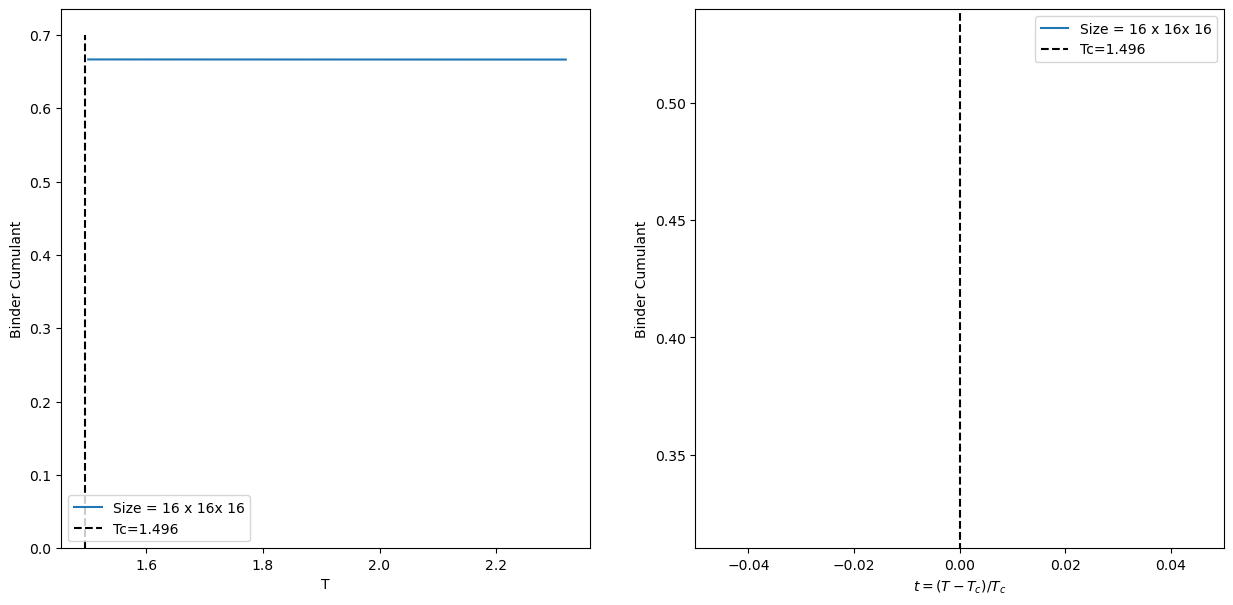

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Tc = 1.492

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.binder_cumulant, label=get_label(data, "size"))
    ax[1].plot((data.temperature-Tc)/Tc, data.binder_cumulant, label=get_label(data, "size"))
    
ax[0].vlines(Tc, 0, 0.7, linestyle="--", color="k", label=f"Tc={Tc}")
ax[1].vlines(0, 0, 0.7, linestyle="--", color="k", label=f"Tc={Tc}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Binder Cumulant")
ax[1].legend(loc="best")
ax[1].set_xlabel(r"$t=(T-T_c)/T_c$")
ax[1].set_xlim([-0.05, 0.05])
ax[1].set_ylim([0.31, 0.54])
ax[1].set_ylabel("Binder Cumulant")

plt.legend()
plt.show()

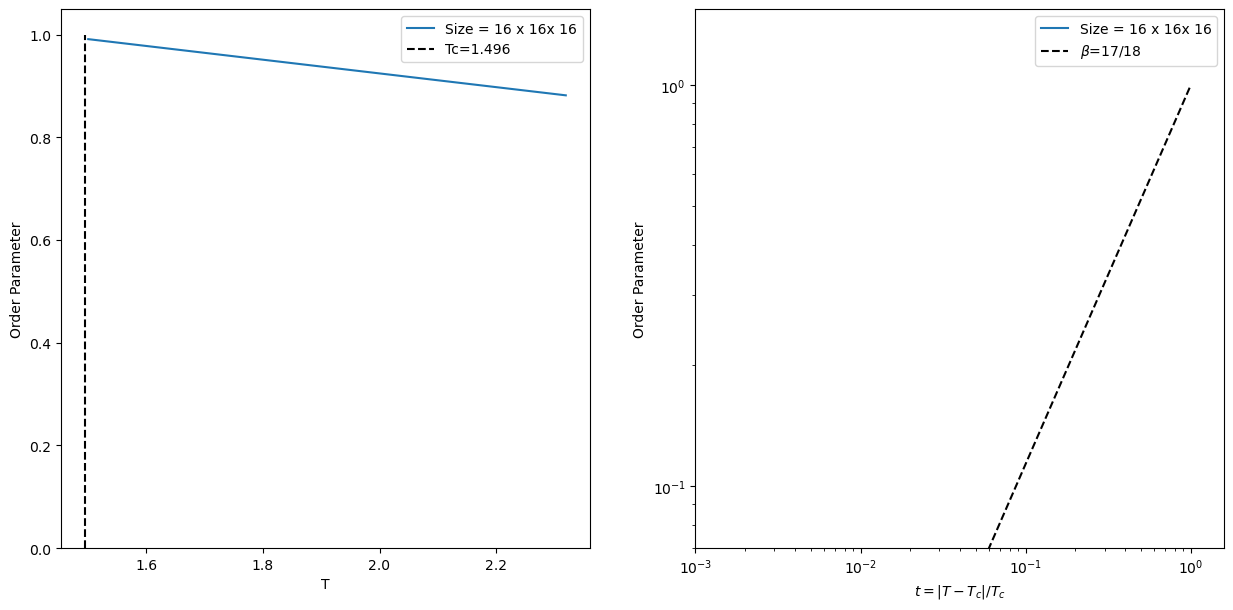

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Tc = 1.492
# beta = 1/9

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.order_parameter, label=get_label(data, "size"))
    ax[1].plot((Tc-data.temperature)/Tc, data.order_parameter, label=get_label(data, "size"))

ax[0].vlines(Tc, 0, 1, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(beta)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color="k", label = fr"$\beta$={beta}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Order Parameter")

ax[1].legend(loc="best")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t=|T-T_c|/T_c$")
ax[1].set_ylabel("Order Parameter")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([7.e-2, None])

plt.legend()
plt.show()

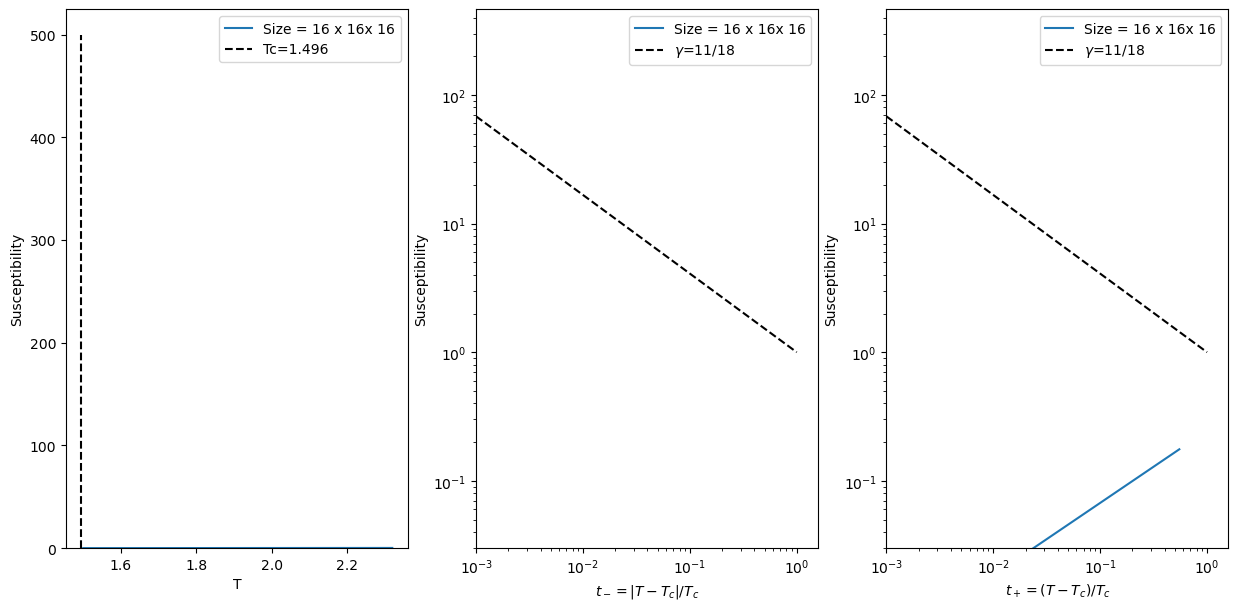

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

# Tc = 1.492
# gamma = 13/9

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.susceptibility, label=get_label(data, "size"))
    ax[1].plot((Tc-data.temperature)/Tc, data.susceptibility, label=get_label(data, "size"))
    ax[2].plot((data.temperature-Tc)/Tc, data.susceptibility, label=get_label(data, "size"))

ax[0].vlines(Tc, 0, 500, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(-gamma)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color="k", label = fr"$\gamma$={gamma}")
ax[2].plot(x, g(x), "--", color="k", label = fr"$\gamma$={gamma}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Susceptibility")

ax[1].legend(loc="best")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Susceptibility")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([3.e-2, None])

ax[2].legend(loc="best")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax[2].set_ylabel("Susceptibility")
ax[2].set_xlim([1.e-3, None])
ax[2].set_ylim([3.e-2, None])

plt.legend()
plt.show()

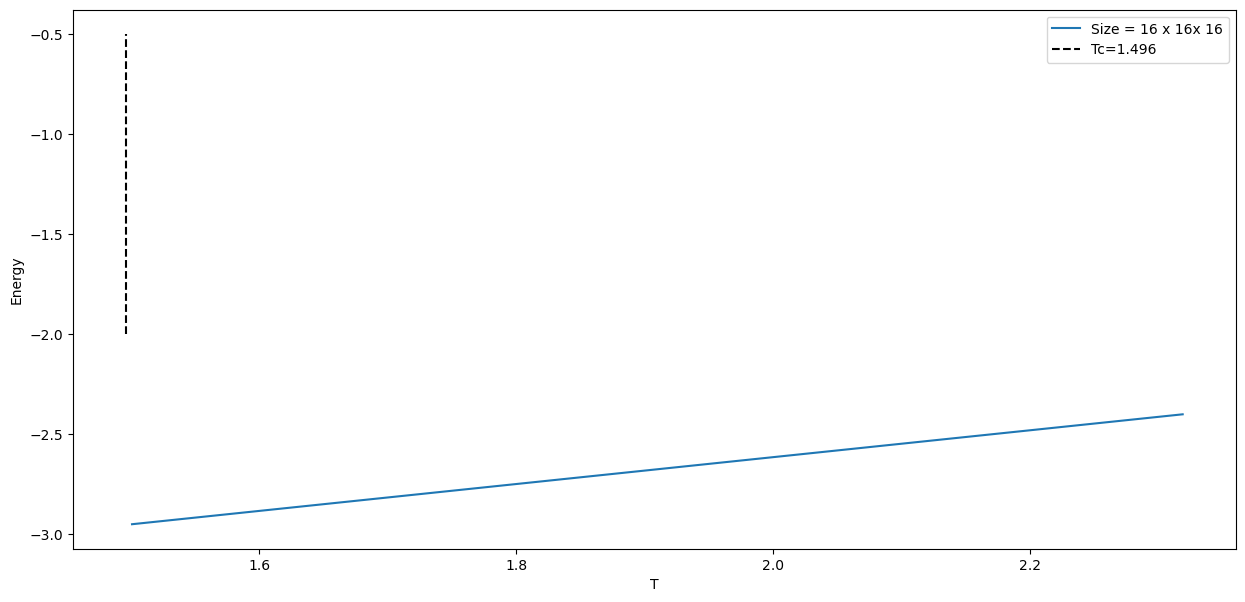

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

# Tc = 1.492

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax.plot(data.temperature, data.energy, label=get_label(data, "size"))

ax.vlines(Tc, -2, -0.5, linestyle="--", color="k", label=f"Tc={Tc}")

# ax.set_ylim([-2, None])
ax.legend(loc="best")
ax.set_xlabel("T")
ax.set_ylabel("Energy")

plt.legend()
plt.show()

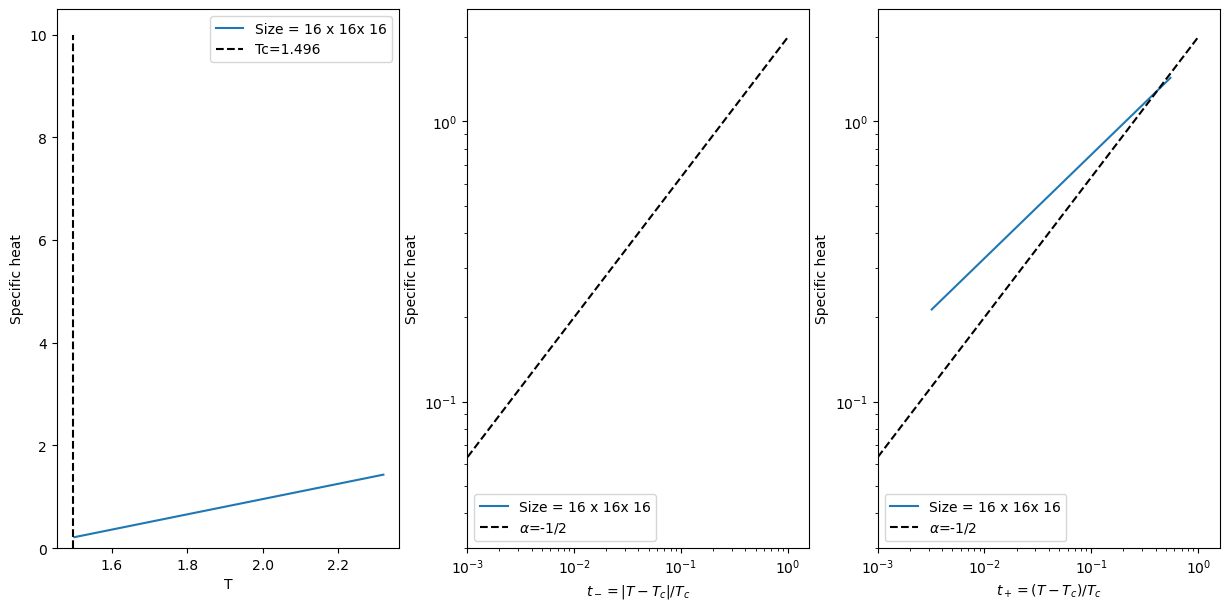

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

# Tc = 1.492
# alpha = 1/3

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.specific_heat, label=get_label(data, "size"))
    ax[1].plot((Tc-data.temperature)/Tc, data.specific_heat, label=get_label(data, "size"))
    ax[2].plot((data.temperature-Tc)/Tc, data.specific_heat, label=get_label(data, "size"))

ax[0].vlines(Tc, 0, 10, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return 2 * x**(-alpha)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color = "black", label = fr"$\alpha$={alpha}")
ax[2].plot(x, g(x), "--", color = "black", label = fr"$\alpha$={alpha}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Specific heat")

ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Specific heat")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([3.e-2, None])
ax[1].legend(loc="lower left")

ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax[2].set_ylabel("Specific heat")
ax[2].set_xlim([1.e-3, None])
ax[2].set_ylim([3.e-2, None])
ax[2].legend(loc="lower left")

plt.show()

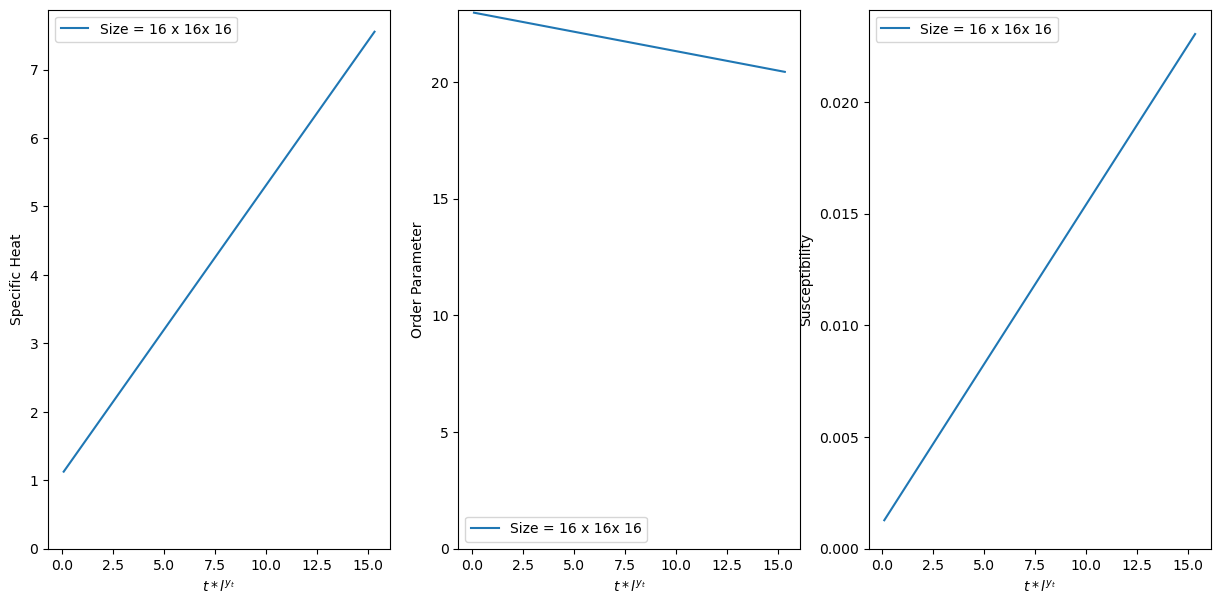

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

# Tc = 1.492
# alpha = 1/3

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot((data.temperature-Tc)/Tc*data.size**yt, data.specific_heat*data.size**(data.dimension-2*yt), label=get_label(data, "size"))
    ax[1].plot((data.temperature-Tc)/Tc*data.size**yt, data.order_parameter*data.size**(data.dimension-yh), label=get_label(data, "size"))
    ax[2].plot((data.temperature-Tc)/Tc*data.size**yt, data.susceptibility*data.size**(data.dimension-2*yh), label=get_label(data, "size"))

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel(r"$t*l^{y_t}$")
ax[0].set_ylabel("Specific Heat")

ax[1].set_ylim([0, None])
ax[1].legend(loc="best")
ax[1].set_xlabel(r"$t*l^{y_t}$")
ax[1].set_ylabel("Order Parameter")

ax[2].set_ylim([0, None])
ax[2].legend(loc="best")
ax[2].set_xlabel(r"$t*l^{y_t}$")
ax[2].set_ylabel("Susceptibility")

plt.show()

ValueError: 32 is not in list

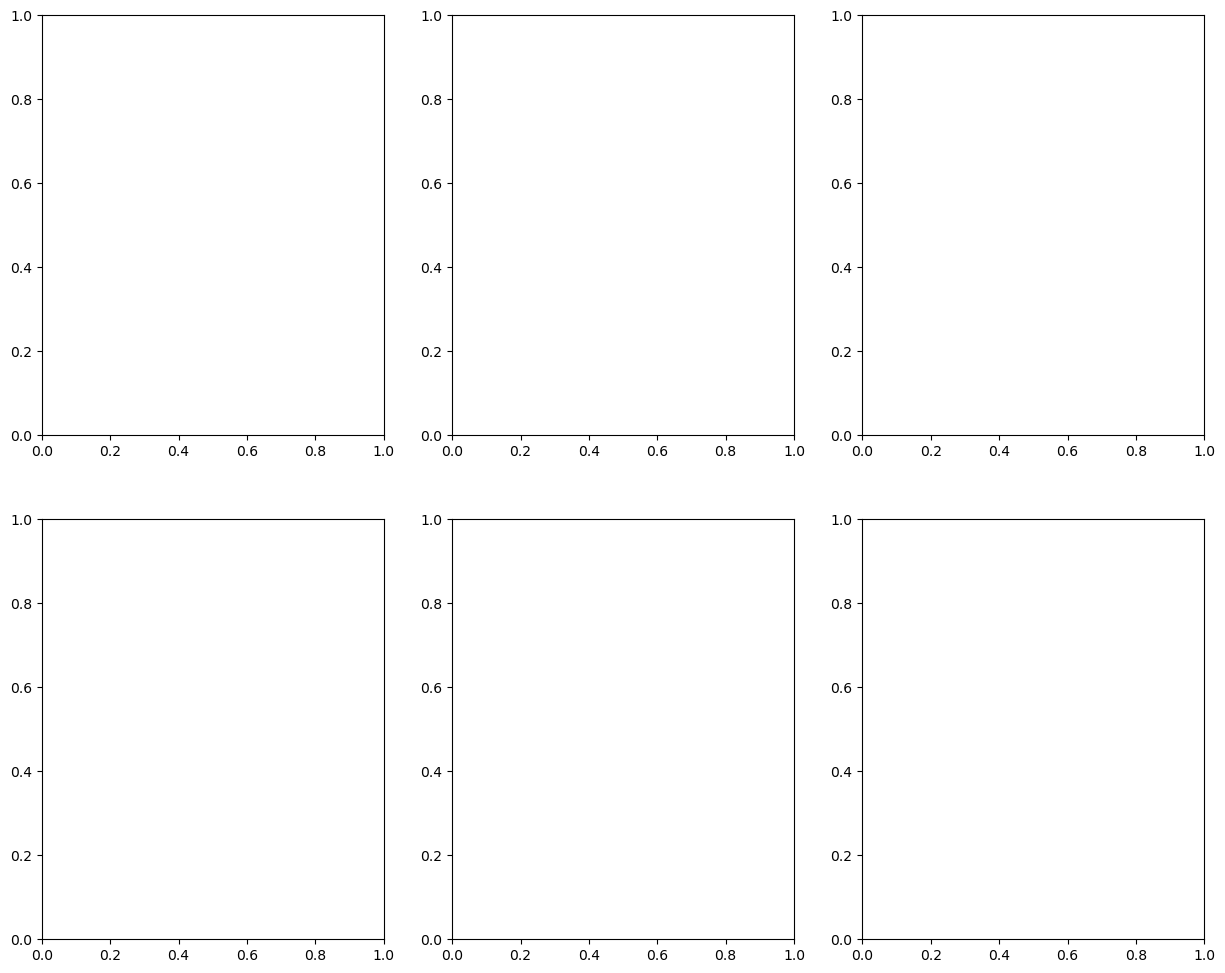

In [17]:
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, _: "{:.8g}".format(y))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

Jv = 0.0

for i, data in enumerate(result[size_list.index(32):size_list.index(128)+1, Jv_list.index(Jv)]):
    for j, irr_dist in enumerate(data.irreducible_distance):
        ax[0,i].plot(irr_dist, data.correlation_function[j])
        ax[1,i].plot(irr_dist, data.correlation_function[j])
    
    def g(x):
        return 1/x**(dimension-2+eta)
    x = np.arange(2,data.size/2)
    ax[1,i].plot(x,g(x),"--",color="k", label=fr"$\eta$={eta}")

    ax[0,i].set_yscale("log")
    ax[0,i].set_xlim(0, data.size*data.dimension/2)
    ax[0,i].set_ylim(3.e-7, 1.)
    ax[0,i].set_xlabel("|i-j|")
    ax[0,i].set_ylabel(f"Correlation Function, {get_label(data, 'size')}")
    
    ax[1,i].loglog()
    ax[1,i].set_xlim(1, data.size*data.dimension/2)
    ax[1,i].set_ylim(0.31, 1.)
    ax[1,i].legend(loc="best")
    ax[1,i].set_xlabel("|i-j|")
    ax[1,i].set_ylabel(f"Correlation Function, {get_label(data, 'size')}")
    
    ax[1,i].xaxis.set_major_formatter(formatter)
    # ax[1,i].xaxis.set_minor_formatter(formatter)
    ax[1,i].yaxis.set_major_formatter(formatter)
    ax[1,i].yaxis.set_minor_formatter(formatter)

# plt.legend()
plt.show()

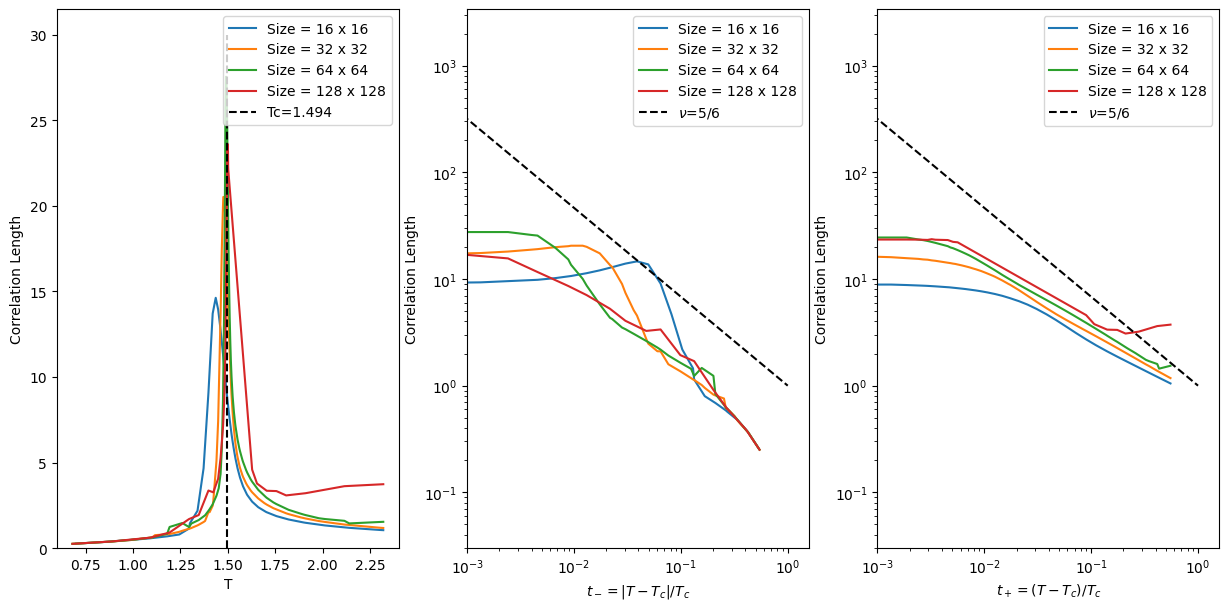

In [ ]:
Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    data.correlation_length = get_correlation_length(data)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

for data in result[size_list.index(16):size_list.index(128)+1, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.correlation_length, label=get_label(data, "size"))
    ax[1].plot((Tc-data.temperature)/Tc, data.correlation_length, label=get_label(data, "size"))
    ax[2].plot((data.temperature-Tc)/Tc, data.correlation_length, label=get_label(data, "size"))

ax[0].vlines(Tc, 0, 30, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(-nu)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color="k", label = fr"$\nu$={nu}")
ax[2].plot(x, g(x), "--", color="k", label = fr"$\nu$={nu}")

ax[0].legend(loc="best")
ax[0].set_ylim([0, None])
ax[0].set_xlabel("T")
ax[0].set_ylabel("Correlation Length")

ax[1].legend(loc="best")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Correlation Length")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([3.e-2, None])

ax[2].legend(loc="best")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax[2].set_ylabel("Correlation Length")
ax[2].set_xlim([1.e-3, None])
ax[2].set_ylim([3.e-2, None])

plt.legend()
plt.show()

In [ ]:
# x_min, x_max = (1, size/max(16/np.sqrt(size),8))

# measure_eta = []

# for i, distance_list in enumerate(np.array(corr["irreducible_distance"])):
#     correlation = np.array(corr["correlation_function"])[i]
#     x, y = [], []
#     for j, distance in enumerate(distance_list):
#         if(x_min <= distance <= x_max):
#             x.append(np.log(distance))
#             y.append(np.log(correlation[j]))
    
#     x, y = np.array(x).reshape((-1, 1)), np.array(y)
    
#     # print(x, y)
#     model = LinearRegression().fit(x, y)
#     measure_eta.append(2-dimension-model.coef_)

# measure_eta = np.average(measure_eta)

# print(f"measure eta = {measure_eta}")
# print(f"real eta: {eta}")

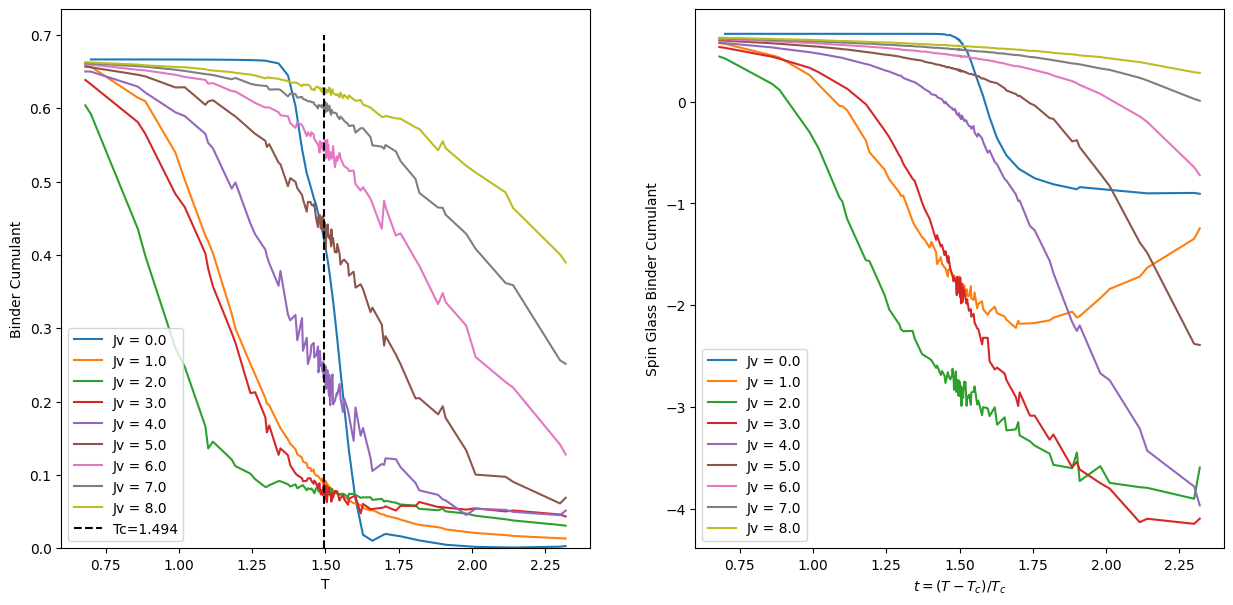

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax[0].plot(data.temperature, data.binder_cumulant, label=get_label(data, "Jv"))
    ax[1].plot(data.temperature, data.spin_glass_binder, label=get_label(data, "Jv"))
    
ax[0].vlines(Tc, 0, 0.7, linestyle="--", color="k", label=f"Tc={Tc}")
# ax[1].vlines(0, 0, 0.7, linestyle="--", color="k", label=f"Tc={Tc}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Binder Cumulant")
ax[1].legend(loc="best")
ax[1].set_xlabel(r"$t=(T-T_c)/T_c$")
# ax[1].set_xlim([-0.05, 0.05])
# ax[1].set_ylim([0.31, 0.54])
ax[1].set_ylabel("Spin Glass Binder Cumulant")

plt.legend()
plt.show()

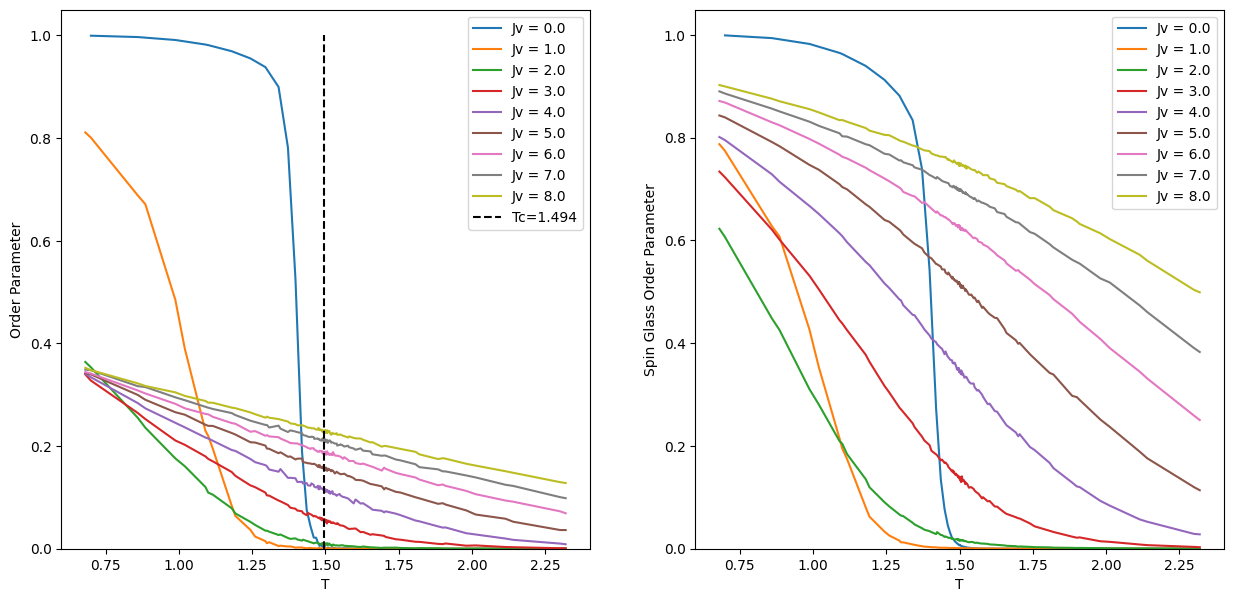

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax[0].plot(data.temperature, data.order_parameter, label=get_label(data, "Jv"))
    ax[1].plot(data.temperature, data.spin_glass_order, label=get_label(data, "Jv"))

ax[0].vlines(Tc, 0, 1, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(beta)
x = np.linspace(0.0001, 1, 100)
# ax[1].plot(x, g(x), "--", color="k", label = fr"$\beta$={beta}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Order Parameter")

ax[1].legend(loc="best")
# ax[1].set_yscale("log")
# ax[1].set_xscale("log")
# ax[1].set_xlabel(r"$t=|T-T_c|/T_c$")
ax[1].set_xlabel("T")
ax[1].set_ylabel("Spin Glass Order Parameter")
# ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([0, None])

plt.legend()
plt.show()

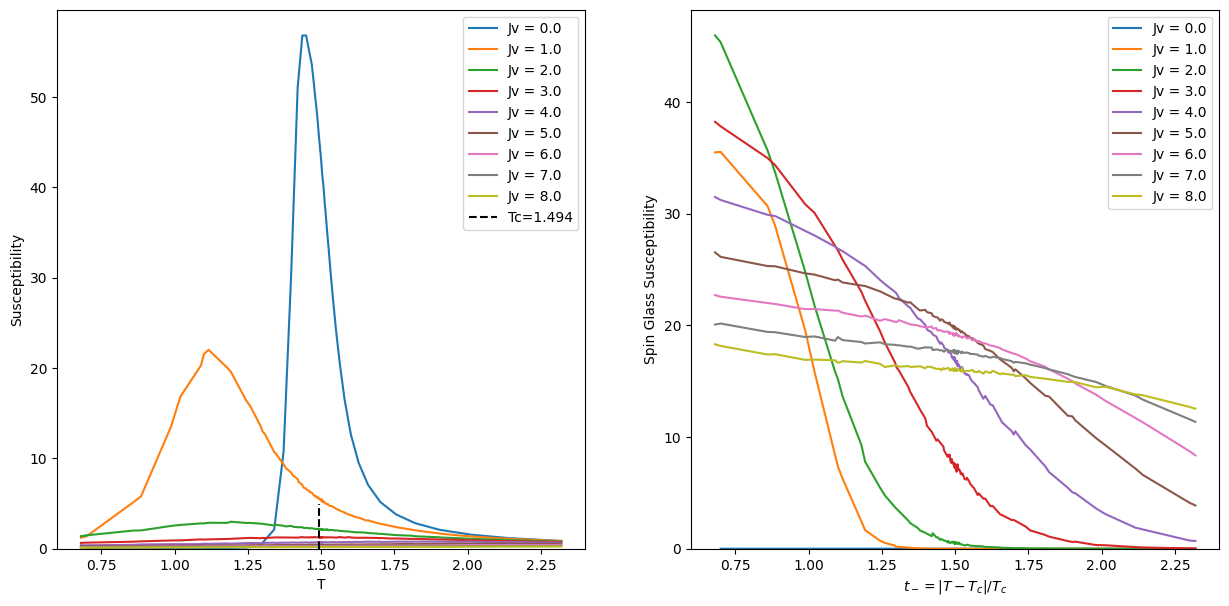

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax[0].plot(data.temperature, data.susceptibility, label=get_label(data, "Jv"))
    ax[1].plot(data.temperature, data.spin_glass_suscept, label=get_label(data, "Jv"))

ax[0].vlines(Tc, 0, 5, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(-gamma)
x = np.linspace(0.0001, 1, 10)
# ax[1].plot(x, g(x), "--", color="k", label = fr"$\gamma$={gamma}")
# ax[2].plot(x, g(x), "--", color="k", label = fr"$\gamma$={gamma}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Susceptibility")

ax[1].legend(loc="best")
# ax[1].set_yscale("log")
# ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Spin Glass Susceptibility")
# ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([0.e-2, None])

plt.legend()
plt.show()

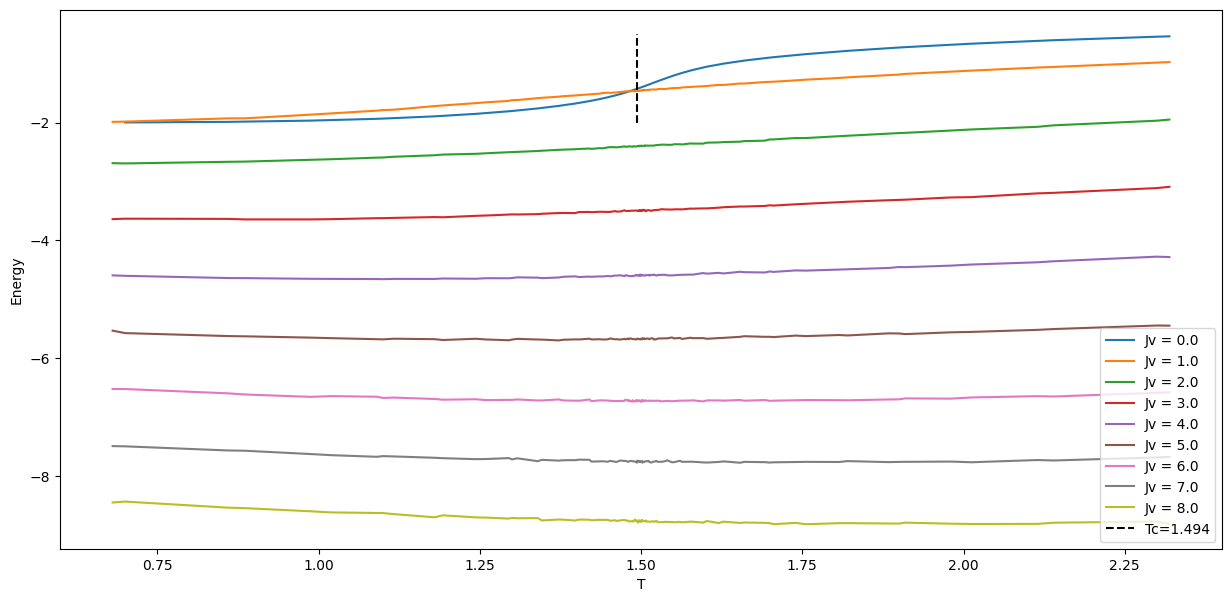

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax.plot(data.temperature, data.energy, label=get_label(data, "Jv"))

ax.vlines(Tc, -2, -0.5, linestyle="--", color="k", label=f"Tc={Tc}")

# ax.set_ylim([-2, None])
ax.legend(loc="best")
ax.set_xlabel("T")
ax.set_ylabel("Energy")

plt.legend()
plt.show()

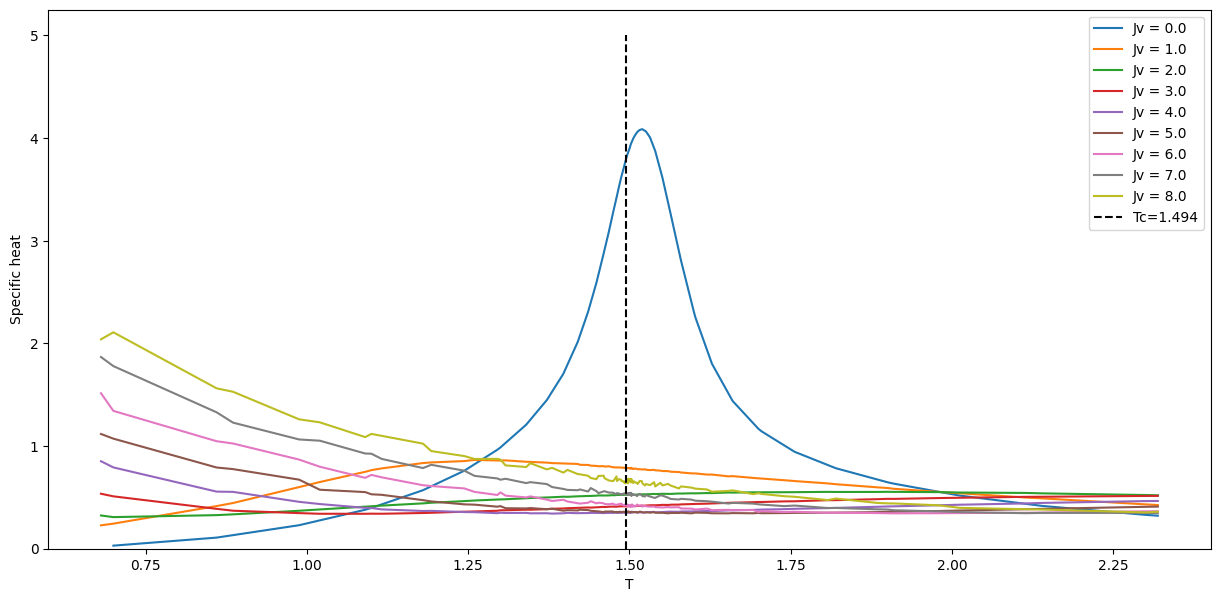

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

size = 16

for data in result[size_list.index(size), :]:
    ax.plot(data.temperature, data.specific_heat, label=get_label(data, "Jv"))

ax.vlines(Tc, 0, 5, linestyle="--", color="k", label=f"Tc={Tc}")


ax.set_ylim([0, None])
ax.legend(loc="best")
ax.set_xlabel("T")
ax.set_ylabel("Specific heat")

plt.show()